In [14]:
# ========================================
# 01 - FLOW FROM DIRECTORY PIPELINE
# ========================================

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# ========================================
# # STEP 1: Configuration
# ========================================
DATASET_DIR = 'dataset_path'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
# ========================================
# STEP 2: Directory Initialization
# ========================================

def find_folder(base, names):
    """Return the first matching folder path that exists."""
    for name in names:
        path = os.path.join(base, name)
        if os.path.exists(path):
            return path
    return None

train_synonyms = ['train', 'training', 'Train', 'Training']
val_synonyms = ['val', 'validation', 'valid', 'Validation', 'Valid']

TRAIN_DIR = find_folder(DATASET_DIR, train_synonyms)
VAL_DIR = find_folder(DATASET_DIR, val_synonyms)

use_split = not (TRAIN_DIR and VAL_DIR)

In [4]:
# ========================================
# STEP 3: Data Generators Conditional Setup
# ========================================

if use_split:
    print("⚠️ No train/val folders found — using validation_split (80/20).")

    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        zoom_range=0.1,
        shear_range=0.05,
        fill_mode='nearest',
        validation_split=0.2
    )

    train_gen = datagen.flow_from_directory(
        DATASET_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_gen = datagen.flow_from_directory(
        DATASET_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

else:
    print(f"✅ Using folders:\n - Train: {TRAIN_DIR}\n - Validation: {VAL_DIR}")

    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )

    datagen_val = ImageDataGenerator(rescale=1./255)

    train_gen = datagen_train.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = datagen_val.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

# ========================================
# Summary
# ========================================
print(f"\n🧾 Dataset Summary:\n"
      f" - Train samples: {train_gen.samples}\n"
      f" - Validation samples: {val_gen.samples}\n"
      f" - Classes: {train_gen.class_indices}")

⚠️ No train/val folders found — using validation_split (80/20).
Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

🧾 Dataset Summary:
 - Train samples: 320
 - Validation samples: 80
 - Classes: {'Bacterial_Pneu': 0, 'COVID': 1, 'Normal': 2, 'Viral_Pneu': 3}


Sample Training Images:


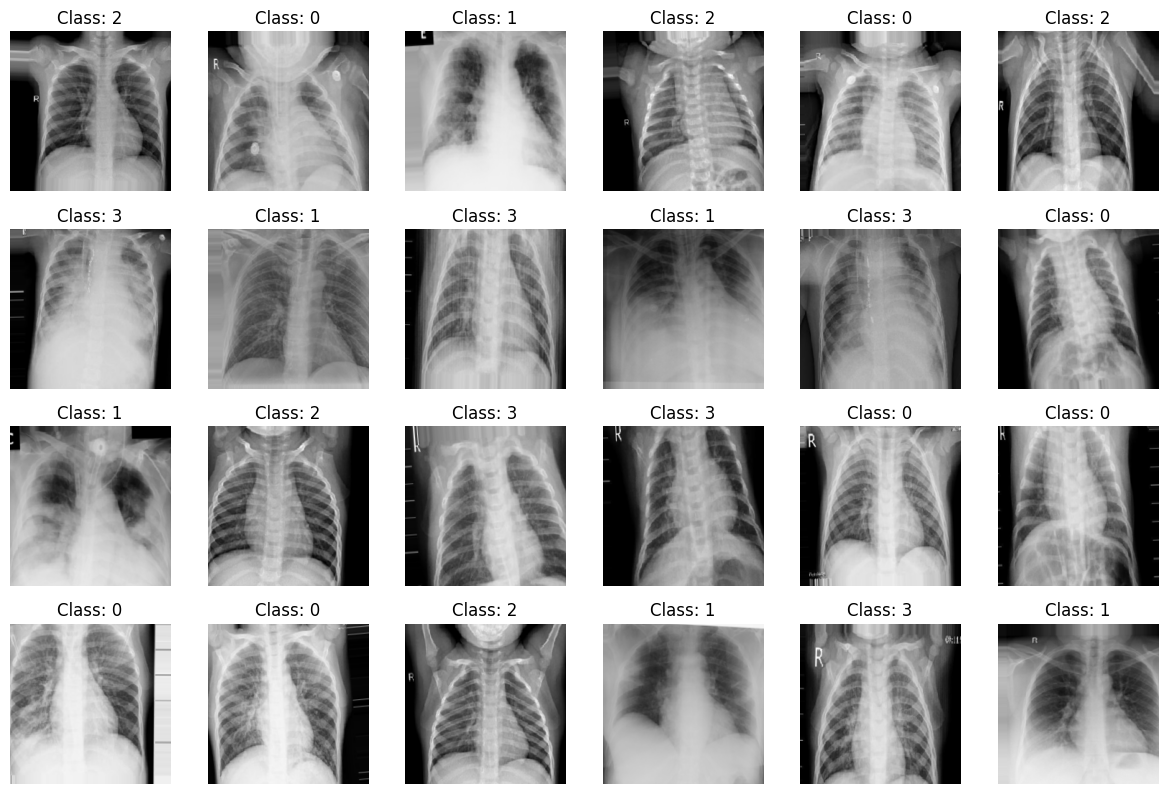

In [5]:
# ========================================
#  Visualize Sample Images
# ========================================

def visualize_batch(generator, num_images=24):
    """Display sample images from the generator"""
    images, labels = next(generator)
    
    plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(images))):
        plt.subplot(6, 6, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize training images
print("Sample Training Images:")
visualize_batch(train_gen)

In [6]:
# ========================================
# Check Generator Information
# ========================================
class_names = list(train_gen.class_indices.keys())

print("\n" + "="*50)
print("GENERATOR INFORMATION")
print("="*50)
print(f"Number of training samples: {train_gen.samples}")
print(f"Number of validation samples: {train_gen.samples}")
print(f"Number of classes: {train_gen.num_classes}")
print(f"Class indices: {train_gen.class_indices}")
print(f"Class Names: {class_names}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Image shape: {(IMG_HEIGHT, IMG_WIDTH, 3)}")


GENERATOR INFORMATION
Number of training samples: 320
Number of validation samples: 320
Number of classes: 4
Class indices: {'Bacterial_Pneu': 0, 'COVID': 1, 'Normal': 2, 'Viral_Pneu': 3}
Class Names: ['Bacterial_Pneu', 'COVID', 'Normal', 'Viral_Pneu']
Batch size: 32
Image shape: (224, 224, 3)


In [15]:
# ========================================
# STEP 4: Build Simple Model
# ========================================

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])
#optimizer = optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
model.summary()



MODEL SUMMARY
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26,

In [16]:

# ========================================
# STEP 5: Train Model
# ========================================

EPOCHS = 10

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
10/10 [==============================] - 4s 311ms/step - loss: 1.8092 - accuracy: 0.2281 - val_loss: 1.3206 - val_accuracy: 0.3750
Epoch 2/10
10/10 [==============================] - 3s 316ms/step - loss: 1.1681 - accuracy: 0.4344 - val_loss: 1.0548 - val_accuracy: 0.4625
Epoch 3/10
10/10 [==============================] - 3s 317ms/step - loss: 0.8992 - accuracy: 0.6156 - val_loss: 0.8439 - val_accuracy: 0.5750
Epoch 4/10
10/10 [==============================] - 3s 324ms/step - loss: 0.7192 - accuracy: 0.6719 - val_loss: 0.7899 - val_accuracy: 0.6625
Epoch 5/10
10/10 [==============================] - 3s 317ms/step - loss: 0.6426 - accuracy: 0.7375 - val_loss: 0.9000 - val_accuracy: 0.6250
Epoch 6/10
10/10 [==============================] - 3s 319ms/step - loss: 0.6647 - accuracy: 0.6687 - val_loss: 0.8373 - val_accuracy: 0.6875
Epoch 7/10
10/10 [==============================] - 3s 318ms/step - loss: 0.6018 - accuracy: 0.7156 - val_loss: 0.6091 - val_accuracy: 0.8000
Epoch 

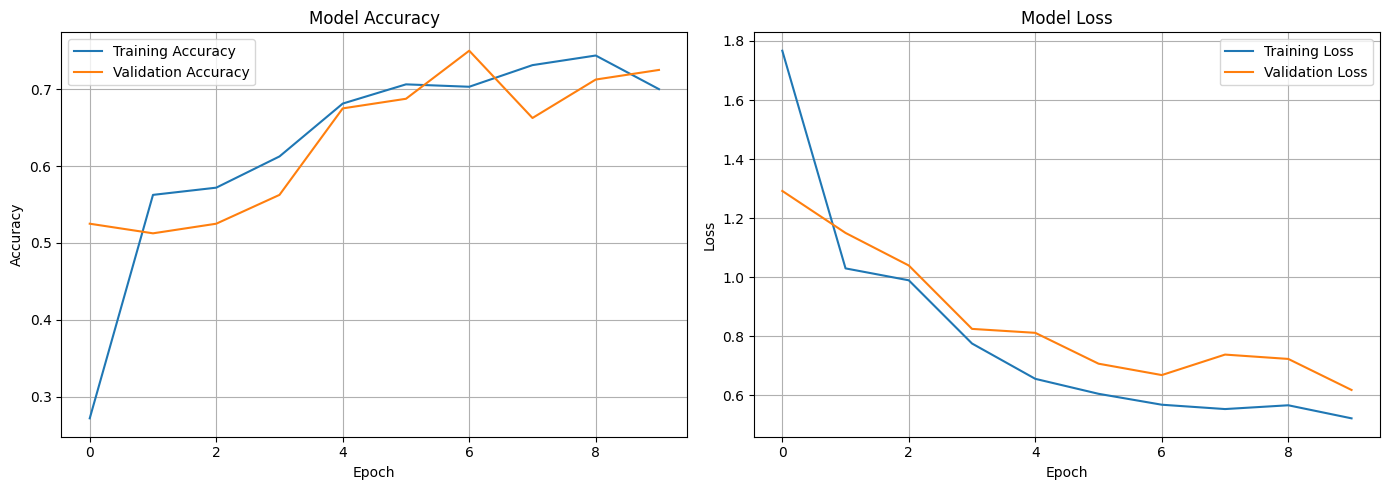

In [9]:
# ========================================
# STEP 6: Results
# ========================================

def plot_history(history):
    """Plot training and validation accuracy/loss"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history)


In [10]:
Y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = val_gen.classes

print(classification_report(y_true_classes, y_pred_classes, target_names=val_gen.class_indices.keys(), digits=4))


3/3 [==============================] - 1s 188ms/step
                precision    recall  f1-score   support

Bacterial_Pneu     0.4706    0.4000    0.4324        20
         COVID     0.9375    0.7500    0.8333        20
        Normal     0.8500    0.8500    0.8500        20
    Viral_Pneu     0.4444    0.6000    0.5106        20

      accuracy                         0.6500        80
     macro avg     0.6756    0.6500    0.6566        80
  weighted avg     0.6756    0.6500    0.6566        80



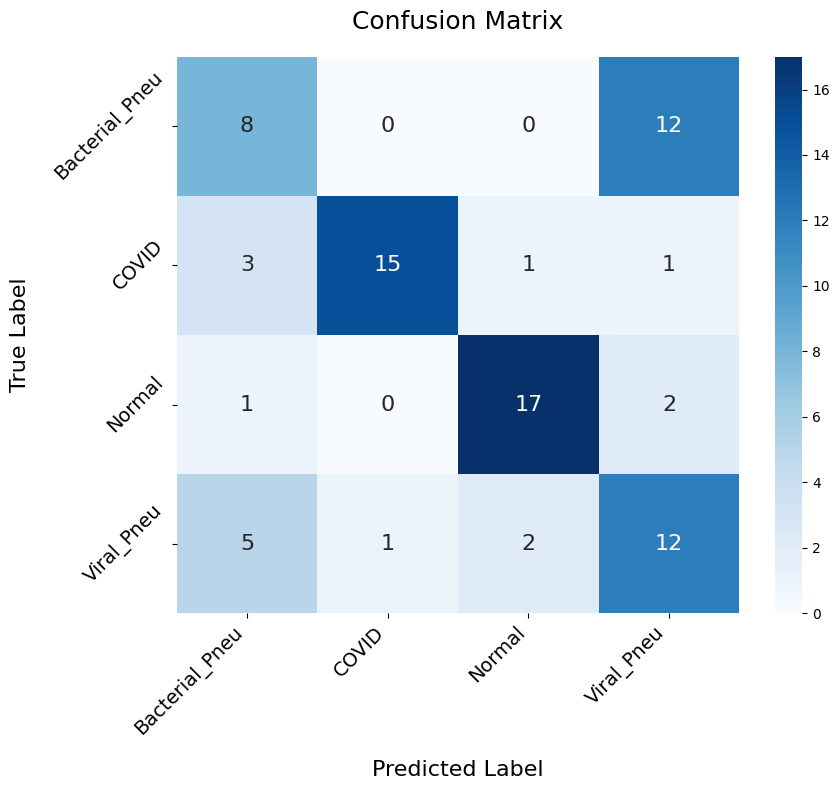

In [11]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(9, 8))  # Increase figure size
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=ax,
    xticklabels=class_names,   # Predicted labels
    yticklabels=class_names,   # True labels
    annot_kws={"size": 16},    # Number font size inside boxes
)

# Titles and axis labels
ax.set_title('Confusion Matrix', fontsize=18, pad=20)
ax.set_xlabel('Predicted Label', fontsize=16, labelpad=15)
ax.set_ylabel('True Label', fontsize=16, labelpad=15)

# Increase tick label size
ax.tick_params(axis='both', labelsize=14)

# Rotate class labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


3/3 [==============================] - 1s 191ms/step


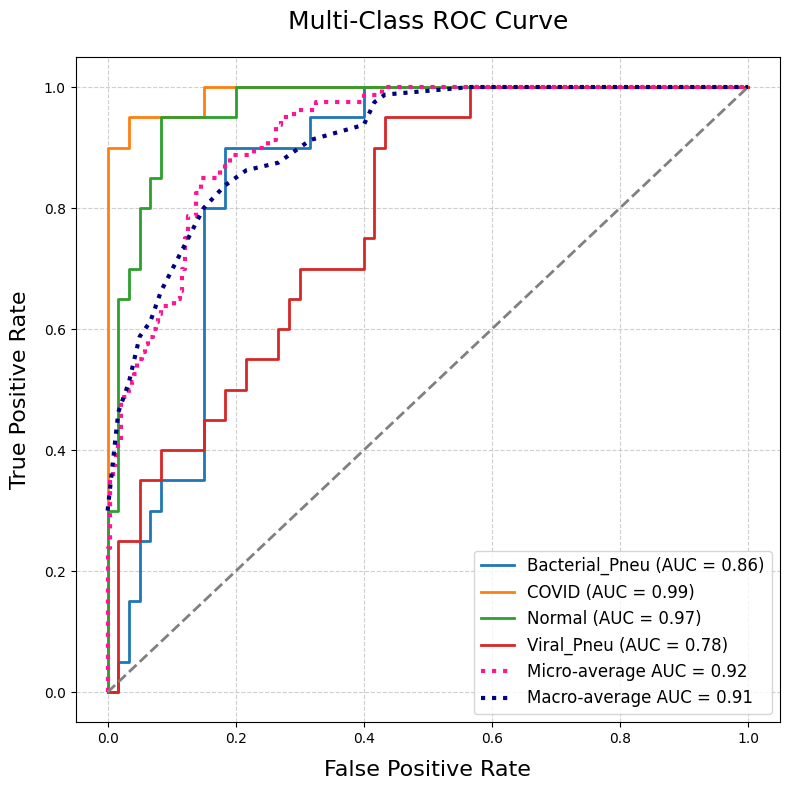

In [12]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the true labels (convert to one-hot format)
y_true_bin = label_binarize(y_true_classes, classes=range(len(class_names)))

# Get predicted probabilities (not predicted classes)
y_pred_prob = model.predict(val_gen)  # Replace x_test with your test data

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average and macro-average ROC and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average (mean of all classes)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 8))

# Plot per-class ROC curves
for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average and macro-average ROC
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=3,
         label=f'Micro-average AUC = {roc_auc_micro:.2f}')
plt.plot(all_fpr, mean_tpr, color='navy', linestyle=':', linewidth=3,
         label=f'Macro-average AUC = {roc_auc_macro:.2f}')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Labels, title, and legend
plt.title('Multi-Class ROC Curve', fontsize=18, pad=20)
plt.xlabel('False Positive Rate', fontsize=16, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=16, labelpad=10)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



SAMPLE PREDICTIONS


1/1 [==============================] - 0s 448ms/step


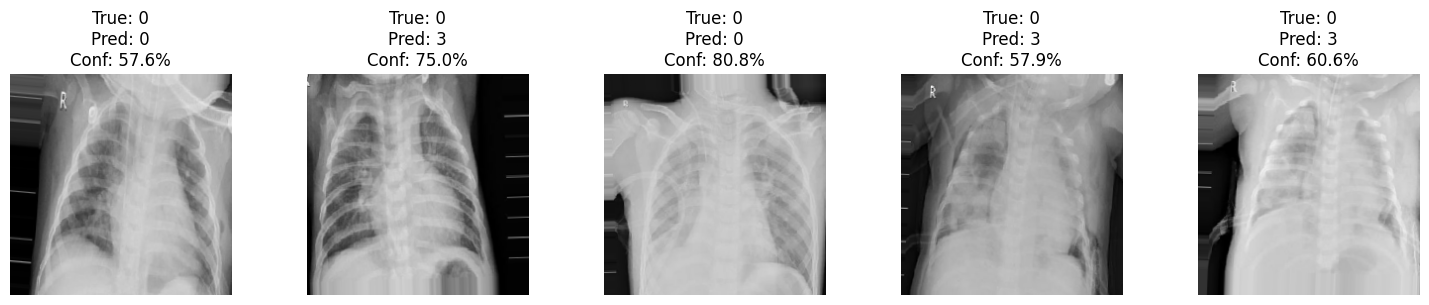

In [13]:
# ========================================
# STEP 7: Make Predictions
# ========================================

def predict_image(model, generator, num_predictions=5):
    """Make predictions on sample images"""
    images, true_labels = next(generator)
    predictions = model.predict(images[:num_predictions])
    
    plt.figure(figsize=(15, 3))
    for i in range(num_predictions):
        plt.subplot(1, num_predictions, i + 1)
        plt.imshow(images[i])
        
        true_class = np.argmax(true_labels[i])
        pred_class = np.argmax(predictions[i])
        confidence = predictions[i][pred_class] * 100
        
        plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50, "\n\n")
predict_image(model, val_gen)
